# Group project in AI applied to engineering - Part 2
This notebook contains the second part of the course project in AI applied to engineering.

### Contents
1. Imports and data loading
2. Review of dataset and declaration of performance metric
3. Training and evaluating
    1. k Neares Neighbor
    2. Logistic regression
    3. Decision Trees
    4. Gaussian Naive Bayes
    5. Support Vector Machines
    6. Bagging
    7. Adaboost
    8. Gradient Boost
    9. Random Forest
    10. Multi Layer Perceptron (MLP)
4. Results summary

## 1. Imports and data loading

In [97]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix
)

In [98]:
X_train = pickle.load(open('X_train_scaled_filtered.pkl', 'rb'))
X_test = pickle.load(open('X_test_scaled_filtered.pkl', 'rb'))
y_train = pickle.load(open('y_train.pkl', 'rb'))
y_test = pickle.load(open('y_test.pkl', 'rb'))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1719, 14), (430, 14), (1719,), (430,))

## 2. Review of dataset and declaration of performance metric

##### Dataset
The dataset we are working with is a dataset containing medical data from just over 2100 patients, of whom some have been diagnosed with Alzheimer's disease.
The data was retrieved from: https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset?resource=download
The dataset contains data from __2149__ patients, and has a total of __35__ data variables. In the last part of the project, the featured in the data set were filtered down from __35__ to __14__, because of low correlation or irrelevance.

##### Performance metric
In this case, recall is the most appropriate performance metric because it reflects the model's ability to correctly identify individuals with Alzheimer’s disease. In a medical context, failing to detect a true case (false negative) is far more serious than incorrectly flagging someone who is healthy. Early detection is crucial for treatment and care planning, so the priority is to minimize the risk of overlooking patients who actually have the disease. While other metrics like precision or specificity can provide additional insight, recall should be prioritized to ensure that as few true cases as possible go undetected.
However, to better understand the types of errors the model makes, we also include the confusion matrix. This allows us to clearly distinguish between false positives and false negatives, which is particularly important in a sensitive context like medical diagnosis. Additionally, although precision is not the primary focus, it is still interesting to consider, especially in cases where over-diagnosis could lead to stress or unnecessary follow-up.

### 3.1 - k Nearest Neighbor

Best k (n_neighbors): 3
k-NN Recall: 0.6423841059602649
k-NN Precision: 0.7185185185185186


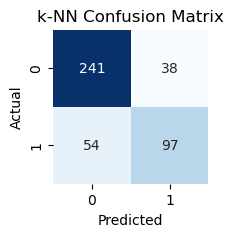

In [99]:
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': list(range(1, 21))}
grid_search = GridSearchCV(knn, param_grid, scoring='recall', cv=5)
grid_search.fit(X_train, y_train)
best_k = grid_search.best_params_['n_neighbors']
print(f"Best k (n_neighbors): {best_k}")

best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test)

recall_knn = recall_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn)

print("k-NN Recall:", recall_knn)
print("k-NN Precision:", precision_knn)


plt.figure(figsize=(2, 2))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('k-NN Confusion Matrix')
plt.show()

### 3.2 - Logistic regression

Best parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best recall score from CV: 0.7291


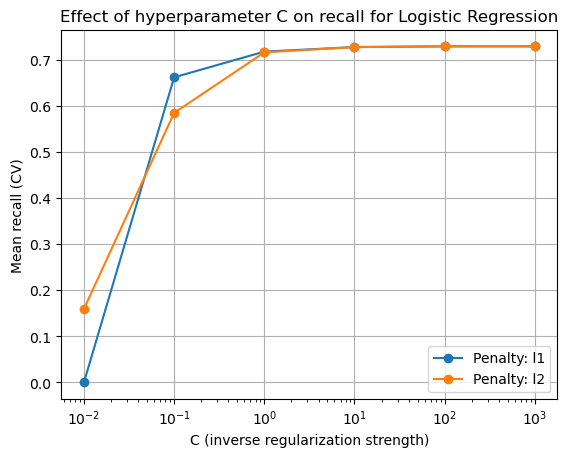


Test set Accuracy: 0.8744
Test set Recall: 0.7483

Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.87      0.94      0.91       279
Alzheimer's (1)       0.88      0.75      0.81       151

       accuracy                           0.87       430
      macro avg       0.87      0.85      0.86       430
   weighted avg       0.87      0.87      0.87       430



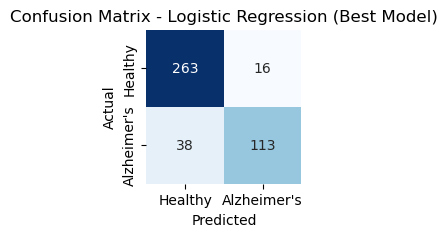

In [100]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

logreg = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(logreg, param_grid, scoring='recall', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

results = pd.DataFrame(grid_search.cv_results_)

for penalty in param_grid['penalty']:
    subset = results[results['param_penalty'] == penalty]
    plt.plot(subset['param_C'], subset['mean_test_score'], marker='o', label=f'Penalty: {penalty}')

plt.xscale('log')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Mean recall (CV)')
plt.title('Effect of hyperparameter C on recall for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

best_logreg = grid_search.best_estimator_
y_pred = best_logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["Healthy (0)", "Alzheimer's (1)"])

print(f"\nTest set Accuracy: {accuracy:.4f}")
print(f"Test set Recall: {recall:.4f}")
print("\nClassification Report:")
print(report)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Logistic Regression (Best Model)")
plt.show()

### 3.3 - Decision trees

Best parameters: {'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 38}
Best recall score from CV: 0.9114

Test set Accuracy: 0.9581
Test set Recall: 0.9205

Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.96      0.98      0.97       279
Alzheimer's (1)       0.96      0.92      0.94       151

       accuracy                           0.96       430
      macro avg       0.96      0.95      0.95       430
   weighted avg       0.96      0.96      0.96       430



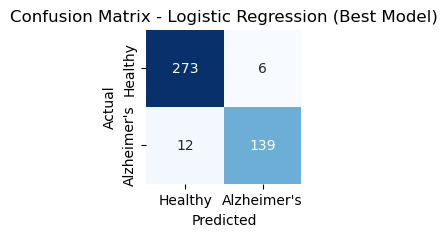

In [101]:
param_grid = {
    'max_depth': [None, 2, 4, 6, 8, 10, 12],
    'min_samples_split': [2, 5, 10, 20, 30, 37, 38, 39, 50, 60, 70, 100, 1000],
    'min_samples_leaf': [1, 2, 4, 8, 16, 32]
}

dtree = DecisionTreeClassifier(random_state=19)
grid_search = GridSearchCV(dtree, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

best_dtree = grid_search.best_estimator_
y_pred_dtree = best_dtree.predict(X_test)
cm = confusion_matrix(y_test, y_pred_dtree)

accuracy = accuracy_score(y_test, y_pred_dtree)
recall = recall_score(y_test, y_pred_dtree)
report = classification_report(y_test, y_pred_dtree, target_names=["Healthy (0)", "Alzheimer's (1)"])

print(f"\nTest set Accuracy: {accuracy:.4f}")
print(f"Test set Recall: {recall:.4f}")
print("\nClassification Report:")
print(report)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Logistic Regression (Best Model)")
plt.show()

### 3.4 - Gaussian Naive Bayes

Accuracy: 0.8186
Recall: 0.6556

Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.83      0.91      0.87       279
Alzheimer's (1)       0.79      0.66      0.72       151

       accuracy                           0.82       430
      macro avg       0.81      0.78      0.79       430
   weighted avg       0.82      0.82      0.81       430



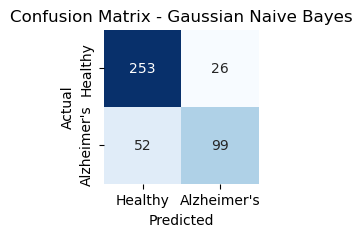

In [102]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_gnb)
recall = recall_score(y_test, y_pred_gnb)
cm = confusion_matrix(y_test, y_pred_gnb)
report = classification_report(y_test, y_pred_gnb, target_names=["Healthy (0)", "Alzheimer's (1)"])

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report:")
print(report)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()

### 3.5 - Support Vector Machines

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Best recall score from CV: 0.8096

Test set Accuracy: 0.8651
Test set Recall: 0.7947

Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.89      0.90      0.90       279
Alzheimer's (1)       0.82      0.79      0.81       151

       accuracy                           0.87       430
      macro avg       0.85      0.85      0.85       430
   weighted avg       0.86      0.87      0.86       430



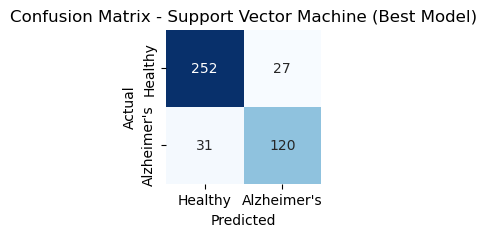

In [103]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

svc = SVC()
grid_search = GridSearchCV(svc, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

best_svc = grid_search.best_estimator_
y_pred_svc = best_svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc)
cm = confusion_matrix(y_test, y_pred_svc)
report = classification_report(y_test, y_pred_svc, target_names=["Healthy (0)", "Alzheimer's (1)"])

print(f"\nTest set Accuracy: {accuracy:.4f}")
print(f"Test set Recall: {recall:.4f}")
print("\nClassification Report:")
print(report)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Support Vector Machine (Best Model)")
plt.show()

### 3.6 - Bagging

Best parameters: {'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 25}
Best recall score from CV: 0.9114

Test set Accuracy: 0.9628
Test set Recall: 0.9272

Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.96      0.98      0.97       279
Alzheimer's (1)       0.97      0.93      0.95       151

       accuracy                           0.96       430
      macro avg       0.96      0.95      0.96       430
   weighted avg       0.96      0.96      0.96       430



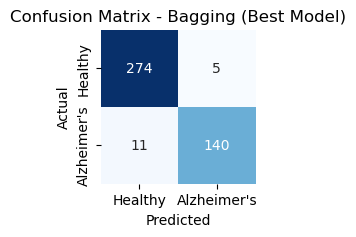

In [104]:
param_grid = {
    'n_estimators': [10, 25, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

bagging = BaggingClassifier(random_state=19)
grid_search = GridSearchCV(bagging, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

best_bagging = grid_search.best_estimator_
y_pred_bagging = best_bagging.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_bagging)
recall = recall_score(y_test, y_pred_bagging)
cm = confusion_matrix(y_test, y_pred_bagging)
report = classification_report(y_test, y_pred_bagging, target_names=["Healthy (0)", "Alzheimer's (1)"])

print(f"\nTest set Accuracy: {accuracy:.4f}")
print(f"Test set Recall: {recall:.4f}")
print("\nClassification Report:")
print(report)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Bagging (Best Model)")
plt.show()

### 3.7 - AdaBoost

Best parameters: {'learning_rate': 0.5, 'n_estimators': 200}
Best recall score from CV: 0.9261

Test set Accuracy: 0.9535
Test set Recall: 0.9272

Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.96      0.97      0.96       279
Alzheimer's (1)       0.94      0.93      0.93       151

       accuracy                           0.95       430
      macro avg       0.95      0.95      0.95       430
   weighted avg       0.95      0.95      0.95       430



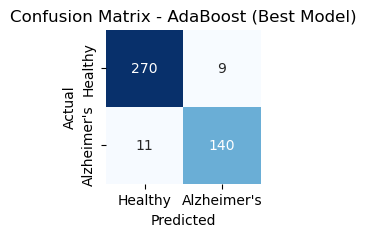

In [105]:
param_grid = {
    'n_estimators': [10, 25, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0, 2.0]
}

adaboost = AdaBoostClassifier(random_state=19)
grid_search = GridSearchCV(adaboost, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

best_adaboost = grid_search.best_estimator_
y_pred_adaboost = best_adaboost.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_adaboost)
recall = recall_score(y_test, y_pred_adaboost)
cm = confusion_matrix(y_test, y_pred_adaboost)
report = classification_report(y_test, y_pred_adaboost, target_names=["Healthy (0)", "Alzheimer's (1)"])

print(f"\nTest set Accuracy: {accuracy:.4f}")
print(f"Test set Recall: {recall:.4f}")
print("\nClassification Report:")
print(report)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - AdaBoost (Best Model)")
plt.show()

### 3.8 - Gradient Boost

Best parameters: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50}
Best recall score from CV: 0.9212

Test set Accuracy: 0.9605
Test set Recall: 0.9205

Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.96      0.98      0.97       279
Alzheimer's (1)       0.97      0.92      0.94       151

       accuracy                           0.96       430
      macro avg       0.96      0.95      0.96       430
   weighted avg       0.96      0.96      0.96       430



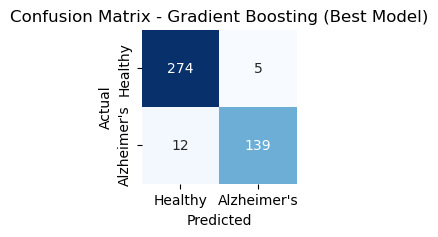

In [106]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
    'max_depth': [2, 3, 4, 5]
}

gbc = GradientBoostingClassifier(random_state=19)
grid_search = GridSearchCV(gbc, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

best_gbc = grid_search.best_estimator_
y_pred_gbc = best_gbc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_gbc)
recall = recall_score(y_test, y_pred_gbc)
cm = confusion_matrix(y_test, y_pred_gbc)
report = classification_report(y_test, y_pred_gbc, target_names=["Healthy (0)", "Alzheimer's (1)"])

print(f"\nTest set Accuracy: {accuracy:.4f}")
print(f"Test set Recall: {recall:.4f}")
print("\nClassification Report:")
print(report)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Gradient Boosting (Best Model)")
plt.show()

### 3.9 - Random Forest

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best recall score from CV: 0.9015

Test set Accuracy: 0.9605
Test set Recall: 0.9205

Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.96      0.98      0.97       279
Alzheimer's (1)       0.97      0.92      0.94       151

       accuracy                           0.96       430
      macro avg       0.96      0.95      0.96       430
   weighted avg       0.96      0.96      0.96       430



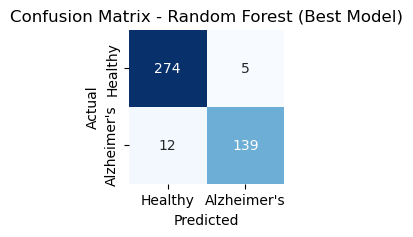

In [107]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=19)
grid_search = GridSearchCV(rf, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
cm = confusion_matrix(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf, target_names=["Healthy (0)", "Alzheimer's (1)"])

print(f"\nTest set Accuracy: {accuracy:.4f}")
print(f"Test set Recall: {recall:.4f}")
print("\nClassification Report:")
print(report)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - Random Forest (Best Model)")
plt.show()

### 3.10 - Multi Layer Perceptron (MLP)

/opt/anaconda3/envs/condaenv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/condaenv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/condaenv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/condaenv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anacond

Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (300, 300, 300, 300), 'learning_rate': 'constant', 'solver': 'adam'}
Best recall score from CV: 0.8161

Test set Accuracy: 0.8581
Test set Recall: 0.7285

Classification Report:
                 precision    recall  f1-score   support

    Healthy (0)       0.86      0.93      0.89       279
Alzheimer's (1)       0.85      0.73      0.78       151

       accuracy                           0.86       430
      macro avg       0.85      0.83      0.84       430
   weighted avg       0.86      0.86      0.86       430



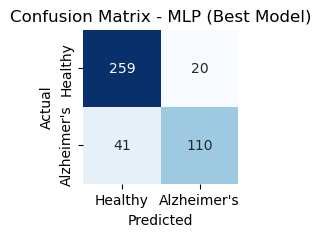

In [108]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100), (300, 300, 300, 300)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(max_iter=500, random_state=19)
grid_search = GridSearchCV(mlp, param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall score from CV: {grid_search.best_score_:.4f}")

best_mlp = grid_search.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_mlp)
recall = recall_score(y_test, y_pred_mlp)
cm = confusion_matrix(y_test, y_pred_mlp)
report = classification_report(y_test, y_pred_mlp, target_names=["Healthy (0)", "Alzheimer's (1)"])

print(f"\nTest set Accuracy: {accuracy:.4f}")
print(f"Test set Recall: {recall:.4f}")
print("\nClassification Report:")
print(report)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Healthy", "Alzheimer's"],
            yticklabels=["Healthy", "Alzheimer's"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix - MLP (Best Model)")
plt.show()

## 4 - Results Summary

The following table shows how the various algorithms perform with respect to recall.

| Model                       | Recall |
|-----------------------------|--------|
| k-Nearest Neighbor          | 0.6423 |
| Logistic Regression         | 0.7483 |
| Decision Tree               | 0.9205 |
| Gaussian Naive Bayes        | 0.6556 |
| Support Vector Machine      | 0.7947 |
| Bagging                     | 0.9272 |
| AdaBoost                    | 0.9272 |
| Gradient Boosting           | 0.9205 |
| Random Forest               | 0.9205 |
| Multi Layer Perceptron (MLP)| 0.8581 |